# Libraries

In [ ]:
# for data processing

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re

# for data pipeline --------------------

from sklearn.model_selection import train_test_split
from sklearn.metrics import*
import matplotlib.pyplot as plt
from sklearn.model_selection import*
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# for prediction (machine learning models) ------------------------

from sklearn.linear_model import*
from sklearn.preprocessing import*
from sklearn.ensemble import*
from sklearn.neighbors import*
from sklearn import svm
from sklearn.naive_bayes import*
import xgboost as xgb

# Data gathering and post data preparation

In [ ]:
train_path='/content/Final_Train.xlsx'
test_path='/content/Final_Test.xlsx'

In [ ]:
train=pd.read_excel(train_path)
test=pd.read_excel(test_path)

#### Primary Visualizations

In [ ]:
train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
0,"BHMS, MD - Homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100
1,"BAMS, MD - Ayurveda Medicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350
2,"MBBS, MS - Otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300
3,"BSc - Zoology, BAMS",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250
4,BAMS,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5961 entries, 0 to 5960
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Qualification       5961 non-null   object
 1   Experience          5961 non-null   object
 2   Rating              2659 non-null   object
 3   Place               5936 non-null   object
 4   Profile             5961 non-null   object
 5   Miscellaneous_Info  3341 non-null   object
 6   Fees                5961 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 326.1+ KB


In [ ]:
test.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info
0,MBBS,35 years experience,NaN,"Ghatkopar East, Mumbai",General Medicine,NaN
1,"MBBS, Diploma in Otorhinolaryngology (DLO)",31 years experience,NaN,"West Marredpally, Hyderabad",ENT Specialist,NaN
2,"MBBS, DDVL",40 years experience,70%,"KK Nagar, Chennai",Dermatologists,"70% 4 Feedback KK Nagar, Chennai"
3,BAMS,0 years experience,NaN,"New Ashok Nagar, Delhi",Ayurveda,NaN
4,"BDS, MDS - Conservative Dentistry & Endodontics",16 years experience,100%,"Kanakpura Road, Bangalore",Dentist,General Dentistry Conservative Dentistry Cosme...


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Qualification       1987 non-null   object
 1   Experience          1987 non-null   object
 2   Rating              897 non-null    object
 3   Place               1981 non-null   object
 4   Profile             1987 non-null   object
 5   Miscellaneous_Info  1153 non-null   object
dtypes: object(6)
memory usage: 93.3+ KB


# Pre-processing

**Miscellaneaous column**

          As the column holds special infomation and blank spaces also, we are going to treat all the non-null as '1' and others as '0'.

In [ ]:
for i in train['Miscellaneous_Info'].value_counts().index:
  train['Miscellaneous_Info'].replace(i,int(1),inplace=True)
train['Miscellaneous_Info'].fillna(int(0),inplace=True)

for i in test['Miscellaneous_Info'].value_counts().index:
  test['Miscellaneous_Info'].replace(i,int(1),inplace=True)
test['Miscellaneous_Info'].fillna(int(0),inplace=True)

**Experience**

      We'll discard all the texts and only put the numeric value ther.

In [ ]:
for i in train['Experience'].value_counts().index:
  ww=i.split()
  train['Experience'].replace(i,int(ww[0]),inplace=True)

for i in test['Experience'].value_counts().index:
  ww=i.split()
  test['Experience'].replace(i,int(ww[0]),inplace=True)

**Place**

    We will split the area and the city into two different features as they can give us hints about the fees.

At first we are going to fill the null values with *(None,None)*

In [ ]:
train['Place'].fillna('None,None',inplace=True)
test['Place'].fillna('None,None',inplace=True)

Now we are going separate the comma separated two types-city and area.

In [ ]:
train['Area']=train['Place'].str.rsplit(',',1).str.get(0)
train['City']=train['Place'].str.rsplit(',',1).str.get(1)
test['Area']=test['Place'].str.rsplit(',',1).str.get(0)
test['City']=test['Place'].str.split(',',1).str.get(1)

train['City']=train['City'].str.strip()
test['City']=test['City'].str.strip()

In [ ]:
train['Area'].isnull().sum(),test['Area'].isnull().sum(),train['City'].isnull().sum(),test['City'].isnull().sum()

(0, 0, 1, 0)

In [ ]:
train[train['City'].isnull()]

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees,Area,City
3980,BDS,23,NaN,e,Dentist,0.0,250,e,NaN


we are going to make this column '*None*' for city and area both

In [ ]:
train.loc[train['City'].isnull(),'Area']='None'
train['City']=train['City'].fillna('None')

In [ ]:
train['Area'].isnull().sum(),test['Area'].isnull().sum(),train['City'].isnull().sum(),test['City'].isnull().sum()

(0, 0, 0, 0)

In [ ]:
train.drop('Place',1,inplace=True)
test.drop('Place',1,inplace=True)


**Qualification**

We are going to check which degrees the doctors have and then treat them as several features.

In [ ]:
train['Qualification'].value_counts()[:30]

BDS                                                      488
BHMS                                                     477
BAMS                                                     471
MBBS                                                     334
MBBS, MS - ENT                                           220
MBBS, MD - Dermatology                                   178
MBBS, MD - General Medicine                              177
MBBS, MD - Dermatology , Venereology & Leprosy           140
BHMS, MD - Homeopathy                                     93
MBBS, DDVL                                                92
MBBS, Diploma in Otorhinolaryngology (DLO)                84
BAMS, MD - Ayurveda Medicine                              82
BDS, MDS - Conservative Dentistry & Endodontics           68
MBBS, DDV                                                 66
BDS, MDS                                                  63
BDS, MDS - Oral & Maxillofacial Surgery                   57
MD - Dermatology , Vener

We can see that - 
    
    MBBS,BDS,BAMS,MD,BHMS,Fellowship,DLO,MLO,DNB,DDVL,MS  , these qualifications are present in a very high number. 
    So, we are going to add features of those and add values '1' or '0' as if they are present or not.


In [ ]:
# func to make feature 
def fun(arr,string):
  for data in dat:
    if data.find(string) !=-1:
      arr.append(int(1))
    else :
      arr.append(int(0))
def to_df(lst):
  lst=pd.DataFrame(lst)
  return lst

cols=['mbbs','bhms','bams','ddvl','dlo','mlo','dnb','bds','md','ms','fellowship']

In [ ]:
dat=train['Qualification']

mbbs=[]
bds=[]
bams=[]
md=[]
bhms=[]
fellowship=[]
dlo=[]
mlo=[]
dnb=[]
ddvl=[]
ms=[]

fun(mbbs,'MBBS')
fun(bds,'BDS')
fun(bams,'BAMS')
fun(md,'MD')
fun(bhms,'BHMS')
fun(fellowship,'Fellowship')
fun(dlo,'DLO')
fun(mlo,'MLO')
fun(dnb,'DNB')
fun(ddvl,'DDVL')
fun(ms,'MS')

mbbs=to_df(mbbs)
bds=to_df(bds)
bams=to_df(bams)
md=to_df(md)
bhms=to_df(bhms)
fellowship=to_df(fellowship)
dlo=to_df(dlo)
mlo=to_df(mlo)
dnb=to_df(dnb)
ddvl=to_df(ddvl)
ms=to_df(ms)

train.drop('Qualification',1,inplace=True)
train=pd.concat([mbbs,bhms,bams,ddvl,dlo,mlo,dnb,bds,md,ms,fellowship,train],axis=1)

mx=train.columns[11:]
for i in mx:
  cols.append(i)
train.columns=cols
train.head()

,mbbs,bhms,bams,ddvl,dlo,mlo,dnb,bds,md,ms,fellowship,Experience,Rating,Profile,Miscellaneous_Info,Fees,Area,City
0,0,1,0,0,0,0,0,0,1,1,0,24,100%,Homeopath,1.0,100,Kakkanad,Ernakulam
1,0,0,1,0,0,0,0,0,1,1,0,12,98%,Ayurveda,1.0,350,Whitefield,Bangalore
2,1,0,0,0,0,0,0,0,0,1,0,9,NaN,ENT Specialist,0.0,300,Mathikere - BEL,Bangalore
3,0,0,1,0,0,0,0,0,0,1,0,12,NaN,Ayurveda,1.0,250,Bannerghatta Road,Bangalore
4,0,0,1,0,0,0,0,0,0,1,0,20,100%,Ayurveda,1.0,250,Keelkattalai,Chennai


In [ ]:
dat=test['Qualification']
mbbs=[]
bds=[]
bams=[]
md=[]
bhms=[]
fellowship=[]
dlo=[]
mlo=[]
dnb=[]
ddvl=[]
ms=[]

dat=test['Qualification']
fun(mbbs,'MBBS')
fun(bds,'BDS')
fun(bams,'BAMS')
fun(md,'MD')
fun(bhms,'BHMS')
fun(fellowship,'Fellowship')
fun(dlo,'DLO')
fun(mlo,'MLO')
fun(dnb,'DNB')
fun(ddvl,'DDVL')
fun(ms,'MS')

mbbs=to_df(mbbs)
bds=to_df(bds)
bams=to_df(bams)
md=to_df(md)
bhms=to_df(bhms)
fellowship=to_df(fellowship)
dlo=to_df(dlo)
mlo=to_df(mlo)
dnb=to_df(dnb)
ddvl=to_df(ddvl)
ms=to_df(ms)

test.drop('Qualification',1,inplace=True)
test=pd.concat([mbbs,bhms,bams,ddvl,dlo,mlo,dnb,bds,md,ms,fellowship,test],axis=1)

cols=['mbbs','bhms','bams','ddvl','dlo','mlo','dnb','bds','md','ms','fellowship']
mx=test.columns[11:]
for i in mx:
  cols.append(i)

test.columns=cols
test.head()

,mbbs,bhms,bams,ddvl,dlo,mlo,dnb,bds,md,ms,fellowship,Experience,Rating,Profile,Miscellaneous_Info,Area,City
0,1,0,0,0,0,0,0,0,0,0,0,35,NaN,General Medicine,0.0,Ghatkopar East,Mumbai
1,1,0,0,0,1,0,0,0,0,0,0,31,NaN,ENT Specialist,0.0,West Marredpally,Hyderabad
2,1,0,0,1,0,0,0,0,0,0,0,40,70%,Dermatologists,1.0,KK Nagar,Chennai
3,0,0,1,0,0,0,0,0,0,1,0,0,NaN,Ayurveda,0.0,New Ashok Nagar,Delhi
4,0,0,0,0,0,0,0,1,1,0,0,16,100%,Dentist,1.0,Kanakpura Road,Bangalore


**Rating**

As the rating column has many null values we are going to put their -99999% and after that we are going to change those percentages into numerical values.

In [ ]:
train['Rating'].fillna('-99999%',inplace=True)
test['Rating'].fillna('-99999%',inplace=True)

for i in train['Rating'].value_counts().index:
  train['Rating'].replace(i,int(i[:-1]),inplace=True)

for i in test['Rating'].value_counts().index:
  test['Rating'].replace(i,int(i[:-1]),inplace=True)

In [ ]:
train.head()

,mbbs,bhms,bams,ddvl,dlo,mlo,dnb,bds,md,ms,fellowship,Experience,Rating,Profile,Miscellaneous_Info,Fees,Area,City
0,0,1,0,0,0,0,0,0,1,1,0,24,100,Homeopath,1.0,100,Kakkanad,Ernakulam
1,0,0,1,0,0,0,0,0,1,1,0,12,98,Ayurveda,1.0,350,Whitefield,Bangalore
2,1,0,0,0,0,0,0,0,0,1,0,9,-99999,ENT Specialist,0.0,300,Mathikere - BEL,Bangalore
3,0,0,1,0,0,0,0,0,0,1,0,12,-99999,Ayurveda,1.0,250,Bannerghatta Road,Bangalore
4,0,0,1,0,0,0,0,0,0,1,0,20,100,Ayurveda,1.0,250,Keelkattalai,Chennai


In [ ]:
train.head()

,mbbs,bhms,bams,ddvl,dlo,mlo,dnb,bds,md,ms,fellowship,Experience,Rating,Profile,Miscellaneous_Info,Fees,Area,City
0,0,1,0,0,0,0,0,0,1,1,0,24,100,Homeopath,1.0,100,Kakkanad,Ernakulam
1,0,0,1,0,0,0,0,0,1,1,0,12,98,Ayurveda,1.0,350,Whitefield,Bangalore
2,1,0,0,0,0,0,0,0,0,1,0,9,-99999,ENT Specialist,0.0,300,Mathikere - BEL,Bangalore
3,0,0,1,0,0,0,0,0,0,1,0,12,-99999,Ayurveda,1.0,250,Bannerghatta Road,Bangalore
4,0,0,1,0,0,0,0,0,0,1,0,20,100,Ayurveda,1.0,250,Keelkattalai,Chennai


# Exploratory Data analysis

In [ ]:
profile=train['Profile'].value_counts().index
Area=train['Area'].value_counts().index
City=train['City'].value_counts().index

**Qualification**

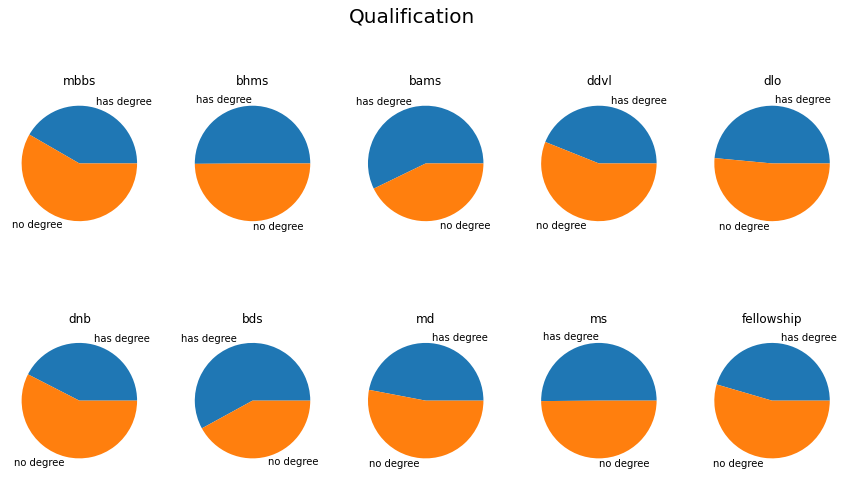

In [ ]:
col1=['mbbs','bhms','bams','ddvl','dlo','dnb','bds','md','ms','fellowship']
lab=['has degree','no degree']
fig,axes=plt.subplots(2,5,figsize=(15,8))
fig.suptitle('Qualification',fontsize=20)
k=1
for col in col1:
  arr=[]
  for i in range(2):
    x=train[train[col]==i]
    arr.append(np.mean(x['Fees']))
  plt.subplot(2,5,k)
  k+=1 
  plt.title(col)
  plt.pie(arr,labels=lab)
plt.show()

It is not showing a greater influence of any singular degree . So we are going to sum up and check again.

In [ ]:
col2=['mbbs','bhms','bams','ddvl','dlo','mlo','dnb','bds','md','ms','fellowship']
summ=np.zeros(len(train))
for i in col2:
  arr=train[i]
  summ=np.add(summ,arr)
temp_df=pd.DataFrame({'qual':summ,'fees':train['Fees']})     # created a dataframe adding all the qualifications into one.


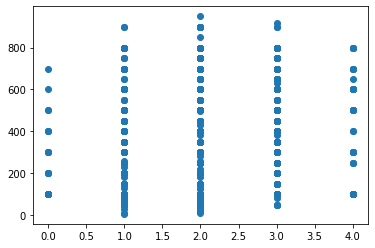

In [ ]:
plt.scatter(temp_df['qual'],temp_df['fees'])

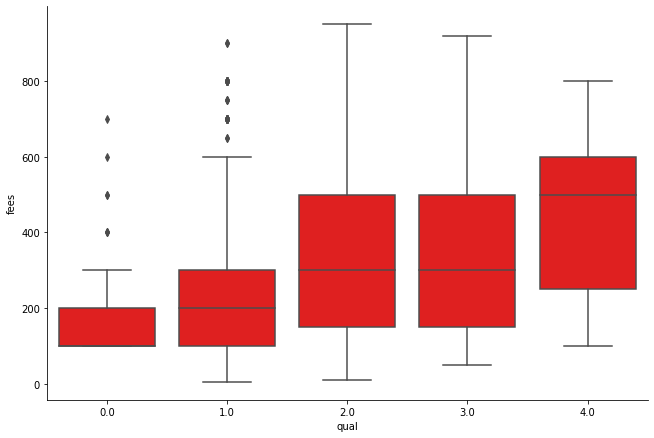

In [ ]:
sns.catplot(x='qual',y='fees', data=temp_df.sort_values("fees"),kind='box',height=6,aspect= 1.5,color='r')
plt.show()

This catplot shows that the charges also vary with the total qualification of the doctors. They increase with increase in number of degrees.

**Profile**

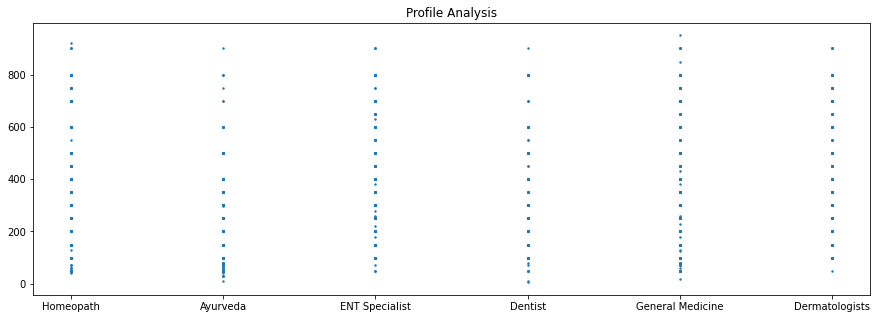

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Profile Analysis')

plt.scatter(train['Profile'],train['Fees'],s=2)
plt.show()

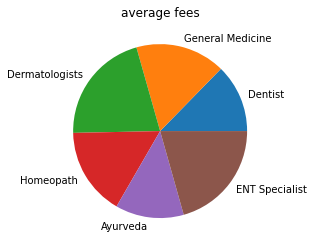

In [ ]:
arr=[]
for i in profile:
  x=train[train['Profile']==i]
  arr.append(np.mean(x['Fees']))
plt.title('average fees')
plt.pie(arr,labels=profile)
plt.show()

It states that '*Ayurveda*' doctors earns some less than others.

whereas the '*Dermatologists*' and the '*ENT*' specialists are earning more.

**Experience**

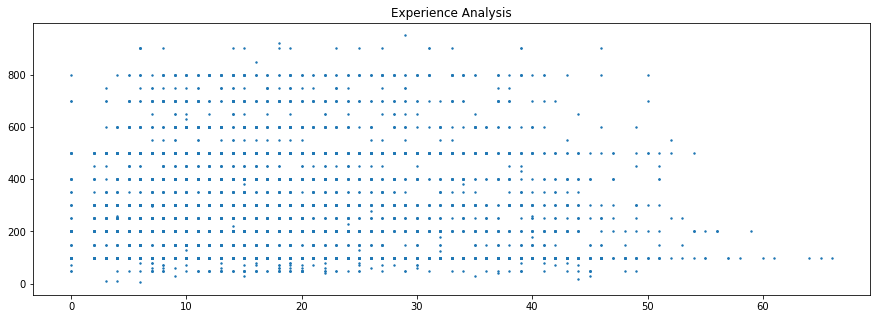

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Experience Analysis')

plt.scatter(train['Experience'],train['Fees'],s=2)
plt.show()

The experience doesn't look quite corelated with the fees.

**Area**

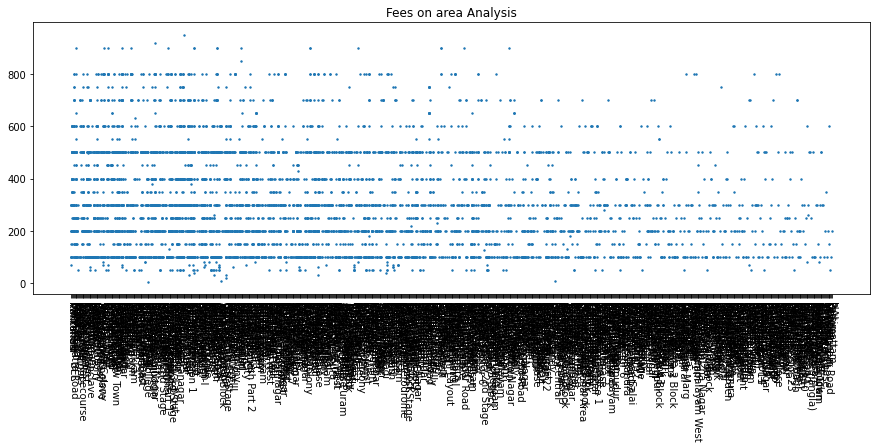

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Fees on area Analysis')

plt.scatter(train['Area'],train['Fees'],s=2)
plt.xticks(rotation=270)
plt.show()

Already the curve shows that this features doesn't varies on wages.

**City**

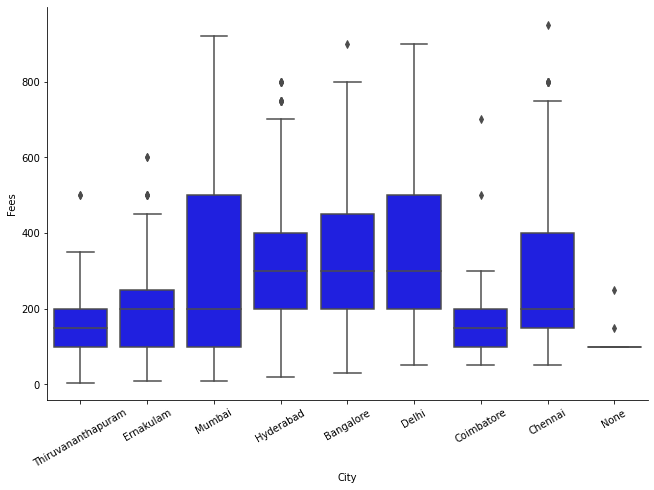

In [ ]:
sns.catplot(x='City',y='Fees', data=train.sort_values("Fees"),kind='box',height=6,aspect= 1.5,color='b')
plt.xticks(rotation=30)
plt.show()

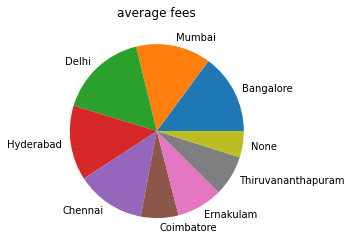

In [ ]:
arr=[]
for i in City:
  x=train[train['City']==i]
  arr.append(np.mean(x['Fees']))
plt.title('average fees')
plt.pie(arr,labels=City)
plt.show()

It shows that the cities are highly correlated with the wages or charges of the doctor.

**Rating**

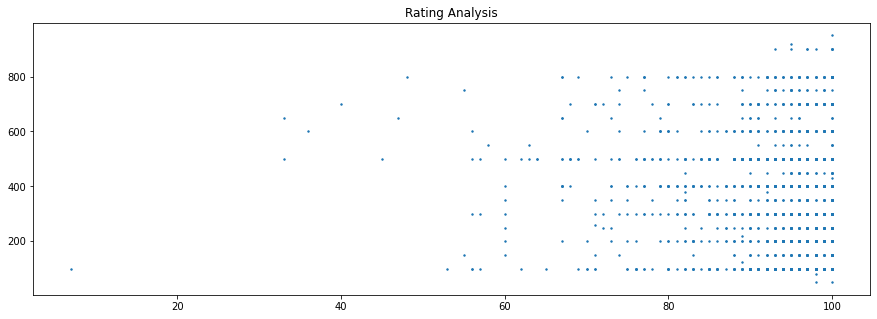

In [ ]:
xx=train[train['Rating']>=0.0]
plt.figure(figsize=(15,5))
plt.title('Rating Analysis')

plt.scatter(xx['Rating'],xx['Fees'],s=2)
plt.show()

Similarly the rating is aslo not giving high correlation with features.

**Miscellaneous Info**

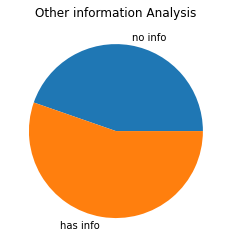

In [ ]:
arr=[]
for i in range(2):
  x=train[train['Miscellaneous_Info']==i]
  arr.append(np.mean(x['Fees']))
plt.title('Other information Analysis')
lab=['no info','has info']

plt.pie(arr,labels=lab)
plt.show()

It is seen that the soctors having other info charges more than others.

#### Final Pre-processing 

We've seen that the qualifications are not informative as segragated but when treated as one. so we are going to drop those features and add a summed version to it.

In [ ]:
train.drop(labels=col2,axis=1,inplace=True)
qual=temp_df['qual']                                         # for train data
qual=to_df(qual)
train=pd.concat([qual,train],axis=1)
train.head()

,qual,Experience,Rating,Profile,Miscellaneous_Info,Fees,Area,City
0,3.0,24,100,Homeopath,1.0,100,Kakkanad,Ernakulam
1,3.0,12,98,Ayurveda,1.0,350,Whitefield,Bangalore
2,2.0,9,-99999,ENT Specialist,0.0,300,Mathikere - BEL,Bangalore
3,2.0,12,-99999,Ayurveda,1.0,250,Bannerghatta Road,Bangalore
4,2.0,20,100,Ayurveda,1.0,250,Keelkattalai,Chennai


In [ ]:
summ=np.zeros(len(test))
for i in col2:
  arr=test[i]
  summ=np.add(summ,arr)
temp_df=pd.DataFrame({'qual':summ})
test.drop(labels=col2,axis=1,inplace=True)
test=pd.concat([temp_df,test],axis=1)
test.head()

,qual,Experience,Rating,Profile,Miscellaneous_Info,Area,City
0,1.0,35,-99999,General Medicine,0.0,Ghatkopar East,Mumbai
1,2.0,31,-99999,ENT Specialist,0.0,West Marredpally,Hyderabad
2,2.0,40,70,Dermatologists,1.0,KK Nagar,Chennai
3,2.0,0,-99999,Ayurveda,0.0,New Ashok Nagar,Delhi
4,2.0,16,100,Dentist,1.0,Kanakpura Road,Bangalore


### Encoding

In [ ]:
profile

Index(['Dentist', 'General Medicine', 'Dermatologists', 'Homeopath',
       'Ayurveda', 'ENT Specialist'],
      dtype='object')

In [ ]:
def encode(str):
  scaler=LabelEncoder()
  ar1=train[str]
  ar1=scaler.fit_transform(ar1)
  train[str]=ar1
  ar2=test[str]
  ar2=scaler.transform(ar2)
  test[str]=ar2
    

In [ ]:
encode('Profile')
encode('City')

In [ ]:
x1=train['Area']
x2=test['Area']
try:
  encode('Area')
except:
  print('ERROR ! New area token found in test.')
  train['Area']=x1
  test['Area']=x2

ERROR ! New area token found in test.


The area has one extra data in test so we are manually encoding the 'area'.

In [ ]:
xx=train['Area'].value_counts().index
xy=test['Area'].value_counts().index
xx=to_df(xx)
xy=to_df(xy)

In [ ]:
x3=pd.concat([xx,xy],axis=0)
x3.columns=['0']
a1=x3['0'].value_counts().index
i=0
for val in a1:
  train['Area'].replace(val,int(i),inplace=True)
  test['Area'].replace(val,int(i),inplace=True)
  i+=1

In [ ]:
test.head()

,qual,Experience,Rating,Profile,Miscellaneous_Info,Area,City
0,1.0,35,-99999,4,0.0,175,6
1,2.0,31,-99999,3,0.0,244,5
2,2.0,40,70,2,1.0,323,1
3,2.0,0,-99999,0,0.0,319,3
4,2.0,16,100,1,1.0,339,0


Now we have encoded and prepared the train and test data for model fitting and evaluation.

### X and Y generation :

we are going to split the X_train and y_train from the train and simply declare the test as X_train as it does not possess any target values.

In [ ]:
X_train=train.drop('Fees',1)
y_train=train['Fees']
X_test=test

In [ ]:
print('shape of the X and Y s')
X_train.shape,y_train.shape,X_test.shape

shape of the X and Y s


((5961, 7), (5961,), (1987, 7))

In [ ]:
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5961 entries, 0 to 5960
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   qual                5961 non-null   float64
 1   Experience          5961 non-null   int64  
 2   Rating              5961 non-null   int64  
 3   Profile             5961 non-null   int64  
 4   Miscellaneous_Info  5961 non-null   float64
 5   Area                5961 non-null   int64  
 6   City                5961 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 326.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   qual                1987 non-null   float64
 1   Experience          1987 non-null   int64  
 2   Rating              1987 non-null   int64  
 3   Profile             1987 non-null   int6

# Model selection and fitting :
 We are going to use 3 classifiers.

 As this is a regression task we are going to take -      ***Random Forest Regressor***

**Random Forest**

In [ ]:
clf=RandomForestRegressor(random_state=0,criterion='mse')
clf.fit(X_train,y_train)
y_pred=clf.predict(X_train)
print('RMSE loss in train :',np.sqrt(mean_squared_error(y_train,y_pred)))

RMSE loss in train : 64.36948527991632


In [ ]:
clf.score(X_train,y_train)

0.886308398056238

If we drop the *Area* column we can get :

In [ ]:
X_tr=X_train.drop('Area',1)
clf.fit(X_tr,y_train)
y_pred=clf.predict(X_tr)
print('RMSE loss in train :',np.sqrt(mean_squared_error(y_train,y_pred)))
print('Accuracy of the model :',clf.score(X_tr,y_train))

RMSE loss in train : 99.91901019851863
Accuracy of the model : 0.7260542547803678


We found out that area is a valuable feature for the data .

In [ ]:
X_tr,X_val,y_tr,y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=0)

In [ ]:
clf.fit(X_tr,y_tr)
y_pred=clf.predict(X_tr)
print('RMSE loss in train :',np.sqrt(mean_squared_error(y_tr,y_pred)))
y_pred=clf.predict(X_val)
print('RMSE loss in validation :',np.sqrt(mean_squared_error(y_val,y_pred)))

RMSE loss in train : 65.69512335172573
RMSE loss in validation : 173.4477255539116


It shows that the model is not overfitted and we can move forward.



# Output generation or deployment of the project :

       1. Now we are going to predict the test data with the model we've build.
       2. After that we are going to turn that into a dataframe.
       3. Then we will produce a 'sample_submission.csv'


and thus our project comes to an **END**.

In [ ]:
y_prediction=clf.predict(X_test)

In [ ]:
for i in range(len(y_prediction)):
  print(y_prediction[i])
  break

181.0


This seems that the fees are in float values. But we need them rounded with 50 as all the fees given in the test set are similar to that.

In [ ]:
def rounding(x):
  m=(x//50)*50
  if m==x:
    return int(x/1.0)
  elif x-m>=25.0:
    return int((m+50)/1.0)
  else:
    return int(m/1.0)

In [ ]:
y_fin=[]
for i in range(len(y_prediction)):
  y_fin.append(rounding(y_prediction[i]))
y_fin=pd.DataFrame({'id':np.arange(1,len(y_fin)+1,1),'Fees':y_fin})
print(y_fin.head())

   id  Fees
0   1   200
1   2   500
2   3   450
3   4   200
4   5   250


In [ ]:
y_fin.to_csv('final_submission.csv',index=False)

# THE END :)